In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict

from portwine.strategies import StrategyBase
from portwine.backtester import Backtester
from portwine.loaders import EODHDMarketDataLoader
from portwine.analyzers import EquityDrawdownAnalyzer, MonteCarloAnalyzer, SeasonalityAnalyzer

In [2]:
"""
    Here we define our custom trading strategy. All strategies are 'online' meaning that they only get
    one day of data at a time to make a decision. This is different than other system that gives you a
    full history back and forth that you can play with.

    With this restriction, we accomplish two things:
        1. No lookahead bias whatsoever. There is never going to be a 'what if' situation where your
        strategy looks great on paper, but because you forgot to shift a signal or you looked ahead and
        built some indicator or pattern on data you shouldn't have.

        2. Direct deployment to an execution environment. You can very easily take any strategy developed
        with Portwine and deploy it live because all you do is put the most recent data into the class, and
        it spits out the actions you need to take. You do not need to muck around with getting large windows
        of data or doing a ton of data cleaning. It's all standardized and simple.

    The specific strategy we are implementing is a simple 'risk-on/risk-off' strategy that switches between
    equities and bonds depending on how the general market is doing, as references by the SPY.
"""

class AdaptiveMomentumStrategy(StrategyBase):
    """
    Step-based implementation of the Adaptive Momentum Strategy.
    
    Strategy logic:
    - Risk on/off determined by SPY's 50 vs 200 day moving average cross
    - If risk on => pick top N equities by momentum (defaults to top 3)
    - If risk off => hold short-term Treasury ETFs
    - Rebalances at the end of each month
    """
    
    def __init__(self, eq_tickers, bond_tickers, eq_lookback=21, spy_signal_fast=50, spy_signal_slow=200, top_n=3):
        """
        Parameters
        ----------
        eq_tickers : list
            List of equity tickers to consider
        bond_tickers : list
            List of bond tickers to consider during risk-off periods
        eq_lookback : int
            Number of days to look back for momentum calculation
        spy_signal_fast : int
            Fast moving average period for SPY (risk on/off signal)
        spy_signal_slow : int
            Slow moving average period for SPY (risk on/off signal)
        top_n : int
            Number of top momentum equities to hold during risk-on periods
        """
        # Ensure lists are not empty
        eq_tickers = eq_tickers if eq_tickers else []
        bond_tickers = bond_tickers if bond_tickers else []
        
        # Combine all tickers we need data for (including SPY for risk signal)
        all_tickers = list(set(eq_tickers + bond_tickers + ["SPY"]))
        super().__init__(all_tickers)
        
        # Store strategy parameters
        self.eq_tickers = eq_tickers.copy()  # Make a copy to avoid references
        self.bond_tickers = bond_tickers.copy()
        self.eq_lookback = eq_lookback
        self.spy_signal_fast = spy_signal_fast
        self.spy_signal_slow = spy_signal_slow
        self.top_n = min(top_n, len(eq_tickers)) if eq_tickers else 0
        
        # Make sure top_n is valid
        if self.top_n <= 0 and eq_tickers:
            self.top_n = min(3, len(eq_tickers))

        """
            Because of the 'online' strategy pattern, all history must be explicitly stored to reference
            when the step function is called.
        """
        
        self.price_history = {ticker: [] for ticker in self.tickers}
        self.dates = []
        self.current_signals = {ticker: 0.0 for ticker in self.tickers}
        self.last_rebalance_ym = None
        
    def is_month_end(self, current_date):
        """
        Determine if this is a month-end rebalance day.
        Matches the pandas groupby approach from the original implementation.
        """
        # If it's the last date in our dataset, treat as month end
        if current_date == self.dates[-1]:
            return True
            
        # Find the next date
        current_idx = self.dates.index(current_date)
        if current_idx >= len(self.dates) - 1:
            return True  # Last date in our history
            
        next_date = self.dates[current_idx + 1]
        
        # It's month end if the next date is in a different month
        return (current_date.year != next_date.year or 
                current_date.month != next_date.month)
    
    def calculate_momentum(self, ticker, current_date):
        """
        Calculate momentum for a ticker based on price history.
        Matches the pandas-based calculation from the original implementation.
        """
        prices = self.price_history[ticker]
        if len(prices) < self.eq_lookback:
            return -999  # Not enough data
        
        # Get the last eq_lookback prices
        recent_prices = prices[-self.eq_lookback:]
        
        # Check for valid data at the endpoints (must have both)
        if recent_prices[0] is None or recent_prices[-1] is None:
            return -999
            
        # Match original implementation's error handling exactly
        try:
            # Final price / initial price - 1
            if recent_prices[0] <= 0:
                return -999  # Avoid division by zero
                
            result = recent_prices[-1] / recent_prices[0] - 1.0
            return result
        except (TypeError, ZeroDivisionError):
            return -999
    
    def get_ma_values(self, ticker, periods):
        """
        Calculate moving average(s) for a ticker for given period(s).
        Matches pandas' rolling().mean() behavior exactly.
        """
        prices = self.price_history[ticker]
        if not isinstance(periods, list):
            periods = [periods]
            
        ma_values = {}
        for period in periods:
            if len(prices) < period:
                ma_values[period] = None
            else:
                # Only calculate if we have a complete window with no None values
                window = prices[-period:]
                if None in window or any(not isinstance(p, (int, float)) for p in window):
                    ma_values[period] = None
                else:
                    ma_values[period] = sum(window) / period
                
        return ma_values if len(periods) > 1 else ma_values[periods[0]]
    
    def is_risk_on(self):
        """
        Determine if we're in a risk-on environment based on SPY MAs.
        Matches the original implementation's approach.
        """
        # First check if SPY is in our price history
        if "SPY" not in self.price_history or not self.price_history["SPY"]:
            return False
            
        # Calculate moving averages
        ma_values = self.get_ma_values("SPY", [self.spy_signal_fast, self.spy_signal_slow])
        
        # If we don't have enough data for both MAs, assume risk-off
        if not isinstance(ma_values, dict):
            # Handle the case where get_ma_values returned a single value
            return False
            
        if ma_values.get(self.spy_signal_fast) is None or ma_values.get(self.spy_signal_slow) is None:
            return False
            
        # Risk on if fast MA > slow MA
        fast_ma = ma_values[self.spy_signal_fast]
        slow_ma = ma_values[self.spy_signal_slow]
        
        if not isinstance(fast_ma, (int, float)) or not isinstance(slow_ma, (int, float)):
            return False
            
        return fast_ma > slow_ma
    
    def forward_fill_price(self, ticker):
        """
        Implement pandas-like forward fill functionality.
        Returns the last valid price for the ticker or None if no valid price exists.
        """
        history = self.price_history[ticker]
        if not history:
            return None
            
        # Start from the most recent and go backwards
        for price in reversed(history):
            if price is not None and isinstance(price, (int, float)):
                return price
                
        return None
    
    def step(self, current_date, daily_data):
        """
        Process each day's data and return allocation signals.
        
        Parameters
        ----------
        current_date : datetime-like
            The current date being processed
        daily_data : dict
            Dictionary of ticker -> daily data or None if not available
            
        Returns
        -------
        dict
            Dictionary of ticker -> weight allocations
        """
        # Add current date to our history
        self.dates.append(current_date)
        
        # Update price history for each ticker
        for ticker in self.tickers:
            price = None
            
            if daily_data.get(ticker) is not None:
                price = daily_data[ticker]['close']
                    
            # If we don't have a valid price for today, use forward fill
            if price is None or not isinstance(price, (int, float)):
                price = self.forward_fill_price(ticker)
                
            # Add the price to our history (could still be None)
            self.price_history[ticker].append(price)
        
        # Check if we should rebalance (end of month)
        current_ym = (current_date.year, current_date.month)
        
        # Only rebalance on month end and if we haven't already rebalanced this month
        if len(self.dates) > 1 and self.is_month_end(current_date) and current_ym != self.last_rebalance_ym:
            # Update last rebalance tracker
            self.last_rebalance_ym = current_ym
            
            # Reset all signals to zero before recalculating
            self.current_signals = {ticker: 0.0 for ticker in self.tickers}
            
            # Determine risk environment
            risk_on = self.is_risk_on()
            
            if risk_on:
                # Risk on: Pick top N equities by momentum
                momentum_scores = {ticker: self.calculate_momentum(ticker, current_date) 
                                   for ticker in self.eq_tickers}
                
                # Sort tickers by momentum score (descending)
                sorted_tickers = sorted(self.eq_tickers, 
                                        key=lambda t: momentum_scores.get(t, -999), 
                                        reverse=True)
                
                # Pick top N
                top_tickers = sorted_tickers[:self.top_n]
                
                # Equal weight across top tickers
                weight = 1.0 / len(top_tickers) if top_tickers else 0.0
                for ticker in top_tickers:
                    self.current_signals[ticker] = weight
            else:
                # Risk off: Pick top 2 bond tickers by momentum
                momentum_scores = {ticker: self.calculate_momentum(ticker, current_date) 
                                   for ticker in self.bond_tickers}
                
                # Sort bond tickers by momentum score (descending)
                sorted_bonds = sorted(self.bond_tickers, 
                                      key=lambda t: momentum_scores.get(t, -999), 
                                      reverse=True)
                
                # Pick top 2 bonds
                top_bonds = sorted_bonds[:2]
                
                # Equal weight across top bond tickers
                weight = 0.5 if len(top_bonds) > 0 else 0.0
                for ticker in top_bonds:
                    self.current_signals[ticker] = weight
        
        # Return current signals (either unchanged or newly calculated)
        return self.current_signals.copy()

In [3]:
"""
    Initialize the EODHD market data loader. It assumes all assets are in CSV files in a single folder named:
        <TICKER>.<EXCHANGE_CODE>.csv

    The backtester will lazily call the data loader when it needs market data for a strategy. Data loaders can
    be extended to work with any type of data. But, for tickers, that data must be adjusted OHLCV with a date
    index.
"""

data_loader = EODHDMarketDataLoader(data_path='../../../Developer/Data/EODHD/us_sorted/US/')
backtester = Backtester(market_data_loader=data_loader)

In [4]:
"""
    We define our strategy parameters here. This is a simple 'risk-on / risk-off' strategy. So, we just need
    a few 'risky' assets when the market is trending up and a few less 'risky' assets when there is a market
    downturn.

    We can also modify things such as the moving average lengths, lookback period, top stocks selected, etc.
    to study the effects they have on the results.
"""

eq_univ = ["QQQ", "SPY", "IWM", "VUG", "VTV"]  # Risky assets (equities)
bond_univ = ["SHY", "IEI"]                     # Safer assets (bonds)

strategy = AdaptiveMomentumStrategy(
    eq_tickers=eq_univ,
    bond_tickers=bond_univ,
    eq_lookback=21,
    spy_signal_fast=50,
    spy_signal_slow=200,
    top_n=3
)

In [5]:
"""
    Now we just have to put the strategy into the backtester to get our results out. The backtester object
    is reusable for any amount of strategies so long as it can fetch the required tickers as specified in the
    strategy objects.

    This makes testing parameters and doing sweeps very easy.
"""

results = backtester.run_backtest(strategy, benchmark_ticker='SPY')

In [6]:
"""
    The backtester gives you the signals/weights returned, the raw data of all the tickers used, the strategy
    returns, and the benchmark returns. This gives you pretty much everything you need to run deep analysis that
    is completely decoupled from the backtester object, giving you complete flexibility to run your analysis.
"""
results.keys()

dict_keys(['signals_df', 'tickers_returns', 'strategy_returns', 'benchmark_returns'])

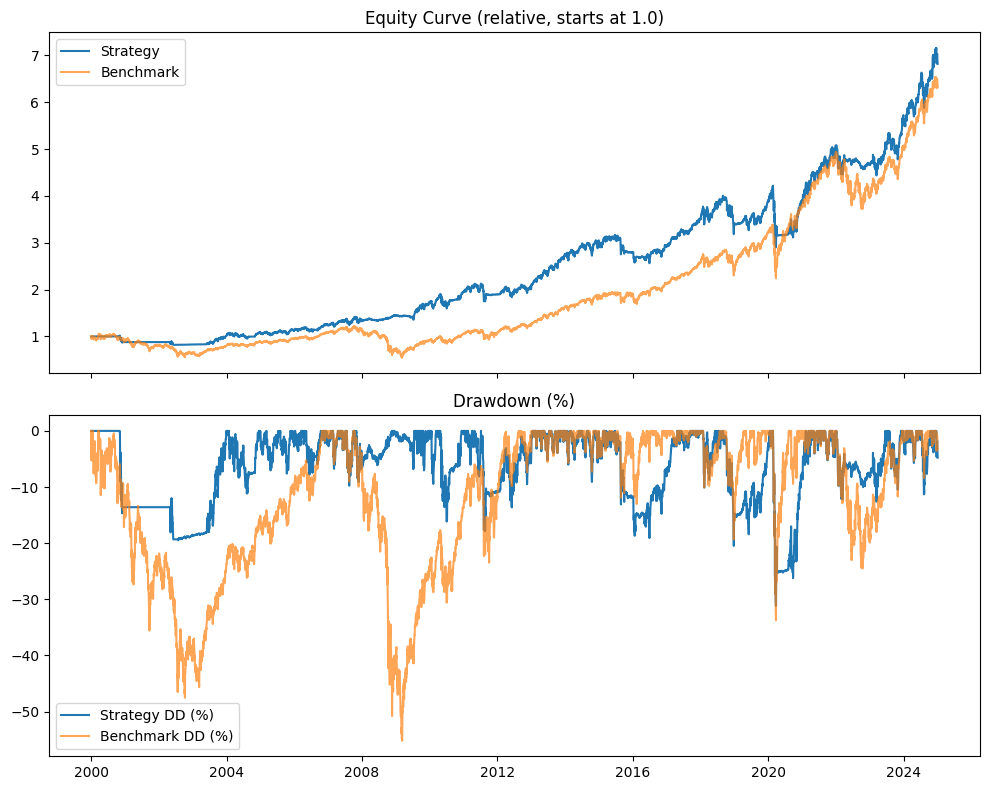

In [7]:
"""
    Every piece of analysis is done outside of the backtester by passing in the results. Even things as 'simple' as
    equity curve plotting and drawdowns. This is so that everything can be compartmentalized and if you want to extend,
    modify, or change any chart or graph, it's extremely easy. You do not need to modify the backtester as is the case
    with other systems.

    Each analyzer has two methods: analyze and plot. Analyze will return you the summary statistics used to generate the
    plots and plot will plot it. Both methods are optional to you as a developer. But, each function must take the results
    dictionary from the backtester as is.
"""

EquityDrawdownAnalyzer().plot(results)

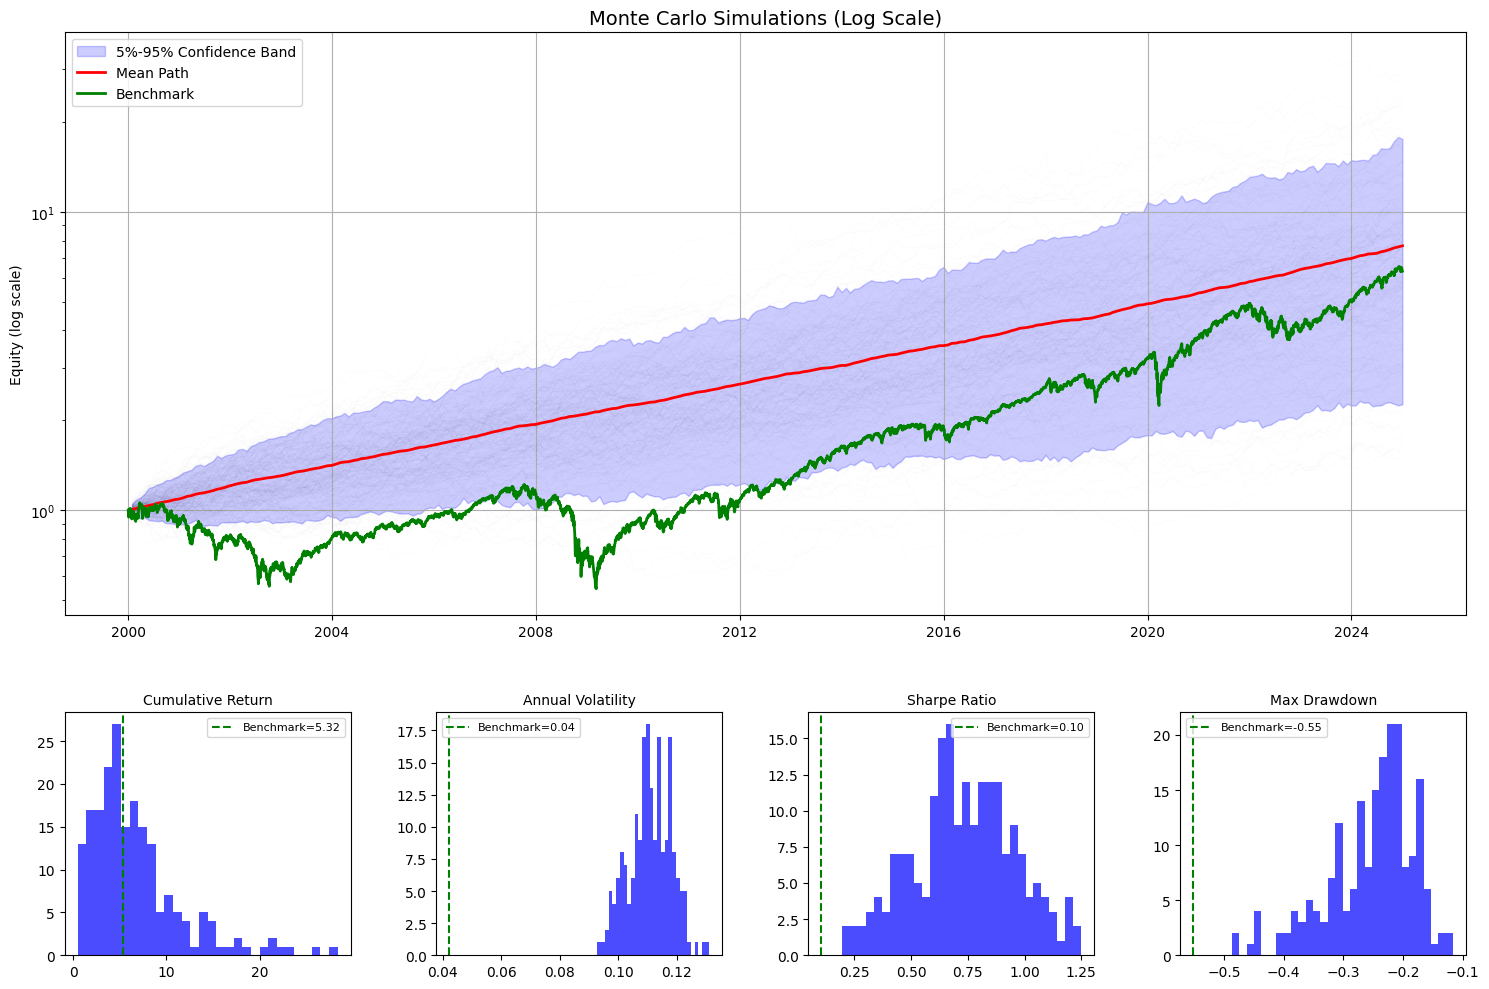

In [8]:
"""
    More advanced analyses are easily handled with this pattern...
"""

MonteCarloAnalyzer().plot(results)

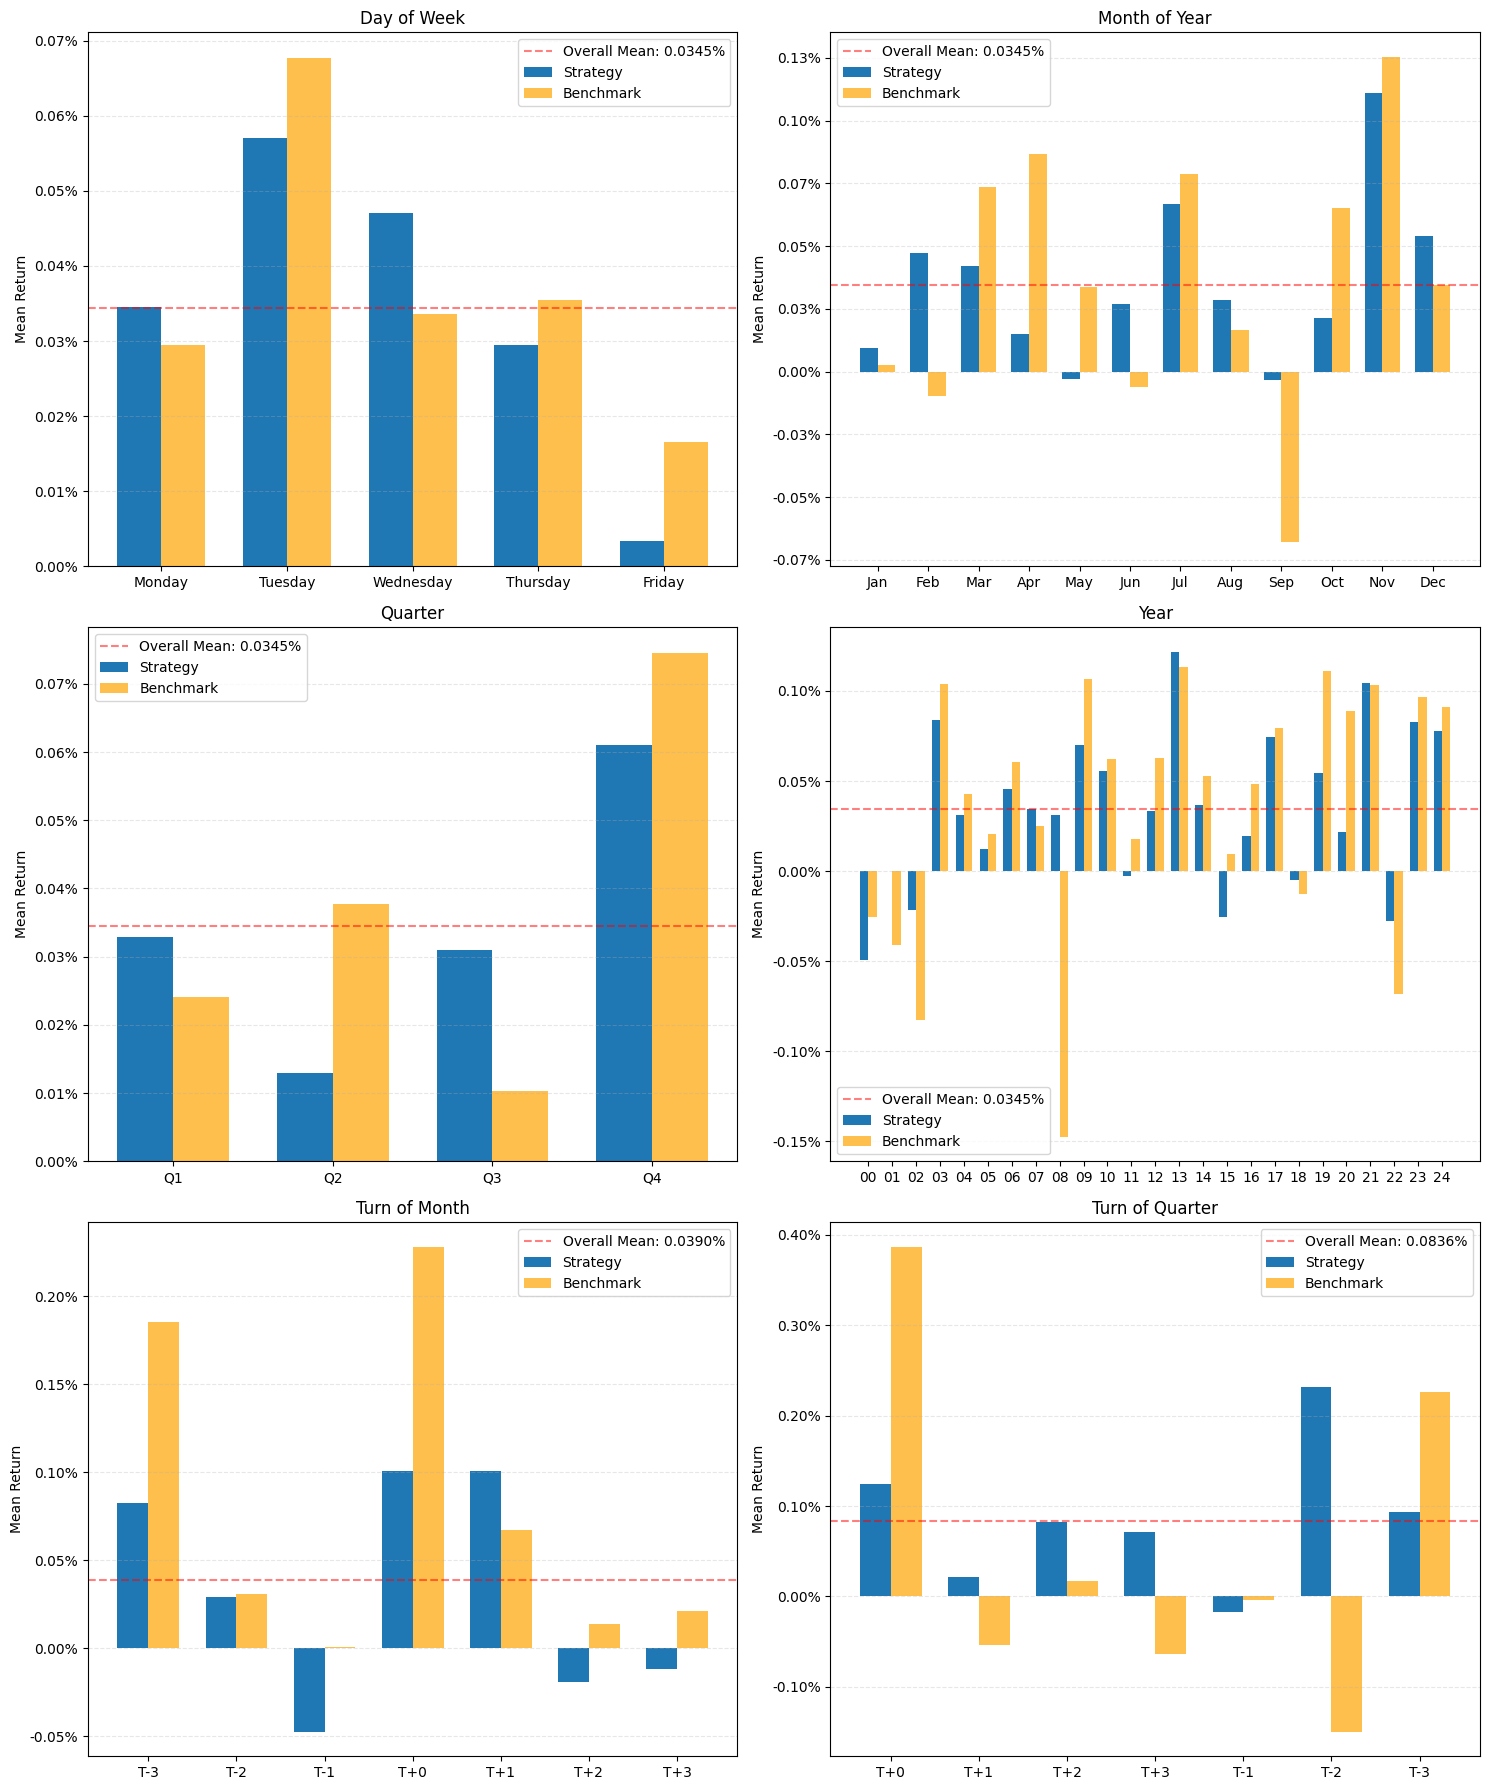

In [9]:
"""
    And even more lengthy analyses with plenty of plots.
"""

SeasonalityAnalyzer().plot(results)

In [10]:
### That's all! Enjoy your research!